# HW03: Distance and Topic Model

Remember that these homework work as a completion grade. **You can skip one section without losing credit.**

## Load and Pre-process Text

In [1]:
#Import the AG news dataset (same as hw01)
#Download them from here 
#!wget https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/train.csv

import pandas as pd
import nltk
df = pd.read_csv('train.csv')

df.columns = ["label", "title", "lead"]
label_map = {1:"world", 2:"sport", 3:"business", 4:"sci/tech"}
def replace_label(x):
	return label_map[x]
df["label"] = df["label"].apply(replace_label) 
df["text"] = df["title"] + " " + df["lead"]
df.head()

,label,title,lead,text
0,business,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...,Carlyle Looks Toward Commercial Aerospace (Reu...
1,business,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...,Oil and Economy Cloud Stocks' Outlook (Reuters...
2,business,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...,Iraq Halts Oil Exports from Main Southern Pipe...
3,business,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco...","Oil prices soar to all-time record, posing new..."
4,business,"Stocks End Up, But Near Year Lows (Reuters)",Reuters - Stocks ended slightly higher on Frid...,"Stocks End Up, But Near Year Lows (Reuters) Re..."


In [2]:
import spacy
dfs = df.sample(200)
nlp = spacy.load('en_core_web_sm')
from sklearn.feature_extraction.text import TfidfVectorizer

##TODO pre-process text as you did in HW02
    
    # process text to work with spacy
dfs['text_processed'] = dfs['text'].apply(lambda x: nlp(x))
    # process tokens to remove punct + stop + digit and make text lowercase
dfs['tokens_processed'] = dfs['text_processed'].apply(lambda doc: [word.lemma_.lower() for word in doc if not word.is_punct and not word.is_stop and not word.is_digit])


##TODO vectorize the pre-processed text using TfidfVectorizer
tfidf = TfidfVectorizer(min_df=0.01, 
                        max_df=0.9,  
                        max_features=1000,
                        stop_words='english',
                        use_idf=True, # the new piece
                        ngram_range=(1,2)) # create features for both 1 and 2-grams

dfs['input_tfidf'] = dfs['tokens_processed'].apply(lambda tok: " ".join(tok))
X_tfidf = tfidf.fit_transform(dfs['input_tfidf'])
print(X_tfidf.shape)

vocab = tfidf.get_feature_names_out()

(200, 803)


## Cosine Similarity and PCA

In [3]:
from sklearn.metrics.pairwise import cosine_similarity
##TODO compute the cosine similarity for the first 200 snippets and for the first snippet, show the three most similar snippets and their respective cosine similarity scores

    # we have already processed the snippets (dfs['input_tfidf']) and vectorised it for a sample of 200 documents
sim = cosine_similarity(X_tfidf)
print(sim.shape)

    # for the first snippet, get the indices of the three highest values, print the value, and the corresponding snippet
snippet_0 = dfs['input_tfidf'].iloc[0]

import numpy as np

snippet_0_score = sim[0, 1:] # Not including the first snippet because they are the same
sorted_index = np.argsort(snippet_0_score)
highest_similarity_index = sorted_index[-3:]

print('First snippet: \'{}\'\nAnd the three most similar snippets are:\n\n'.format(snippet_0))

for i in np.flip(highest_similarity_index):
    score = snippet_0_score[i]
    snip = dfs['input_tfidf'].iloc[i]
    print('{}. Score: {:.5f} ; Snippet: {}'.format(i, score, snip))

(200, 200)
First snippet: 'buddle edson buddle score career good team record goal host columbus crew beat metrostars night secure playoff spot extend unbeaten streak game'
And the three most similar snippets are:


162. Score: 0.21995 ; Snippet: mountain high week historic victory pittsburgh uconn 39;s big east conference member -he huskies match conference 39;s good team west virginia
161. Score: 0.21230 ; Snippet: italian troop   39;to stay iraq italy say intention withdraw 3,000 troop iraq face demand kidnapper seize italian journalist
150. Score: 0.14644 ; Snippet: blatter criticise   39;childish england player sepp blatter president football 39;s world govern body fifa tell sven goran eriksson today england player wrong boycott medium week


In [4]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3,svd_solver='randomized')

##TODO reduce the vectorized data using PCA
X_tfidf_pca = pca.fit_transform(X_tfidf.toarray())
print('Dims X_tfidf_pca: {}'.format(X_tfidf_pca.shape))

##TODO compute again cosine similarity with the reduced version for the first 200 snippets
sim_pca = cosine_similarity(X_tfidf_pca)
print(sim_pca.shape)


##TODO for the first snippet, show again its three most similar snippets
    # for the first snippet, get the indices of the three highest values, print the value, and the corresponding snippet

snippet_0_score_pca = sim_pca[0, 1:] # Not including the first snippet because they are the same
sorted_index = np.argsort(snippet_0_score_pca)
highest_similarity_index_pca = sorted_index[-3:]

print('First snippet: \'{}\'\nAnd the three most similar snippets are:\n\n'.format(snippet_0))

for i in np.flip(highest_similarity_index_pca):
    score = snippet_0_score_pca[i]
    snip = dfs['input_tfidf'].iloc[i]
    print('{}. Score: {:.5f} ; Snippet: {}'.format(i, score, snip))

Dims X_tfidf_pca: (200, 3)
(200, 200)
First snippet: 'buddle edson buddle score career good team record goal host columbus crew beat metrostars night secure playoff spot extend unbeaten streak game'
And the three most similar snippets are:


32. Score: 0.99868 ; Snippet: computer associates cut workforce -wsj computer associates international inc. ca.n quote profile research lay percent work force attempt cut cost wall street journal report wednesday
27. Score: 0.99185 ; Snippet: lilly launches clinical trial web site drug maker eli lilly co. report wednesday launch clinical trial database web site announce intention create site august
163. Score: 0.98889 ; Snippet: gloom forecast badly red sox want post win american league championship series match night rain wash game showdown yankees fenway park game play tonight 8:19 customer ticket night rainout mark   quot;home game


Compare the cosine similarity before and after PCA reduction. Did the results change? 

## Clustering

In [5]:
# !pip install scikit-learn-extra
from sklearn_extra.cluster import KMedoids
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

##TODO create the clusters found with k-medoids clustering nd 5 clusters
kmed = KMedoids(n_clusters=5)
kmed.fit(X_tfidf)
kmed_doc_clusters = kmed.labels_.tolist()
##TODO create the clusters found with k-means clustering nd 5 clusters
kmeans = KMeans(n_clusters=5)
kmeans.fit(X_tfidf)
kmeans_doc_clusters = kmeans.labels_.tolist()

c:\Users\manth\.conda\envs\lm_lss\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [17]:
kmed.cluster_centers_.shape

(5, 803)

(200, 2)


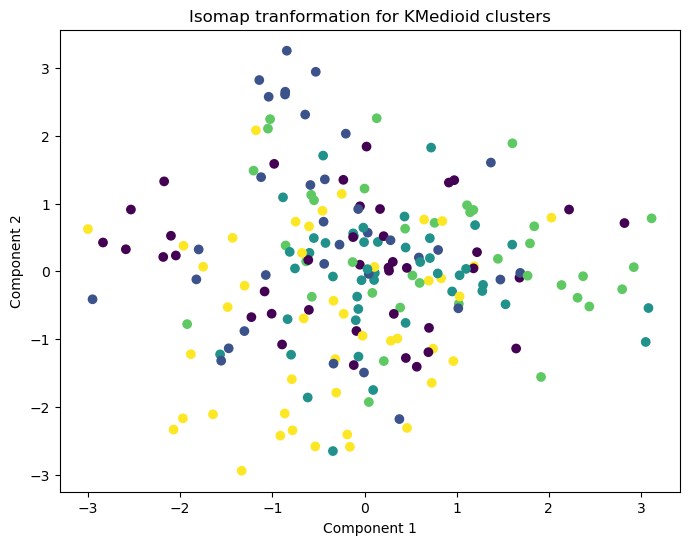

In [20]:
##TODO visualize the k-medoids clustering results through Isomap (first reduce the dimensionality to 2 using Isomap, then use scatter plot (plt.scatter()) to visualize)
from sklearn.manifold import Isomap
import matplotlib.pyplot as plt

iso = Isomap(n_components=2)
iso_kmed = iso.fit_transform(X_tfidf)
print(iso_kmed.shape)


# Plot the transformed data
plt.figure(figsize=(8, 6))
plt.scatter(x=iso_kmed[:, 0], y=iso_kmed[:, 1], c=kmed_doc_clusters)
plt.title('Isomap tranformation for KMedioid clusters')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

(200, 2)


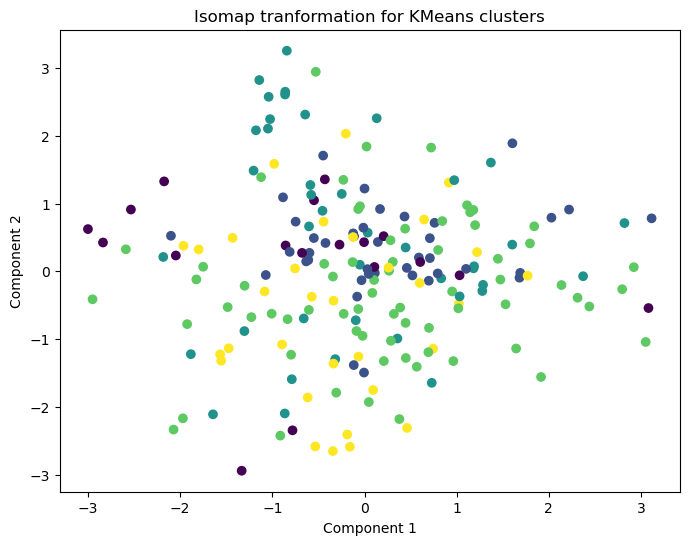

In [22]:
##TODO similarly, visualize the k-means results
iso_kmeans = iso.fit_transform(X_tfidf)
print(iso_kmeans.shape)


# Plot the transformed data
plt.figure(figsize=(8, 6))
plt.scatter(x=iso_kmeans[:, 0], y=iso_kmeans[:, 1], c=kmeans_doc_clusters)
plt.title('Isomap tranformation for KMeans clusters')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

## Topic Modeling: LDA

For this part you will need to use LDA Mallet. If you cannot have Mallet run, you can use the simple LDA algorithm 

In [9]:
from gensim.corpora import Dictionary
from gensim.models.wrappers import LdaMallet
from gensim.models.coherencemodel import CoherenceModel

##TODO create a dictionary with the pre-processed tokenized text and filter it according to frequencies and keeping 1000 vocabularies

##TODO create the doc_term_matrix

ModuleNotFoundError: No module named 'gensim.models.wrappers'

In [ ]:
# !wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
# !unzip mallet-2.0.8.zip

In [ ]:
##TODO train a LDA Mallet model with 5, 10 and 15 topics
##TODO compute the coherence score for each of these model and print the topics from the model with highest coherence score. Then find the opitimal number of topics using the coherence score.

In [ ]:
#!pip install pyLDAvis
import pyLDAvis.gensim
from gensim.models import wrappers
##TODO using LDAvis visualize the topics using the optimal number of topics

In [24]:
import os

os.system('jupyter nbconvert --to html homework_03.ipynb')

0